In [1]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.9 MB/s eta 0:00:00a 0:00:01


In [29]:
# %% [markdown]
# # Step 3: Enhanced Model Training with Hyperparameter Tuning

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')


In [30]:
# Try importing lightgbm, but don't fail if not available
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("✓ LightGBM is available")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("✗ LightGBM not installed. Will use alternative models.")

# Check XGBoost version
print(f"XGBoost version: {xgb.__version__}")

# %%
# Load preprocessed data
X_train = pd.read_csv('../feature_engineered_data/X_train.csv')
X_val = pd.read_csv('../feature_engineered_data/X_val.csv')
X_test = pd.read_csv('../feature_engineered_data/X_test.csv')
y_train = pd.read_csv('../feature_engineered_data/y_train.csv')
y_val = pd.read_csv('../feature_engineered_data/y_val.csv')
y_test = pd.read_csv('../feature_engineered_data/y_test.csv')

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTraining period: {y_train.index[0]} to {y_train.index[-1]}")
print(f"Validation period: {y_val.index[0]} to {y_val.index[-1]}")
print(f"Test period: {y_test.index[0]} to {y_test.index[-1]}")

✓ LightGBM is available
XGBoost version: 3.2.0
X_train shape: (4718, 21)
X_val shape: (273, 21)
X_test shape: (458, 21)

Training period: 0 to 4717
Validation period: 0 to 272
Test period: 0 to 457


In [31]:
# Check if target columns exist
available_targets = []
if 'LP_92' in y_train.columns:
    available_targets.append('LP_92')
if 'LAD' in y_train.columns:
    available_targets.append('LAD')

print(f"\nAvailable target variables: {available_targets}")


Available target variables: ['LP_92', 'LAD']


In [32]:
 # %% [markdown]
# ## Enhanced XGBoost with Hyperparameter Tuning

# %%
def train_xgboost_with_tuning(X_train, y_train, X_val, y_val, target_name):
    """
    Train XGBoost with hyperparameter tuning
    """
    # Convert to numpy arrays
    X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
    X_val_np = X_val.values if hasattr(X_val, 'values') else X_val
    y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
    y_val_np = y_val.values if hasattr(y_val, 'values') else y_val
    
    # Combine train and validation for final training
    X_combined = np.vstack([X_train_np, X_val_np])
    y_combined = np.concatenate([y_train_np, y_val_np])
    
    # Parameter grid for tuning
    param_grid = {
        'n_estimators': [300, 500, 700],
        'max_depth': [6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
    
    # Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Base model
    base_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    
    print(f"  Tuning hyperparameters for {target_name}...")
    # Grid search with limited combinations for speed
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid={k: v for k, v in list(param_grid.items())[:3]},  # Use fewer params for speed
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_np, y_train_np)
    
    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Best CV score: {-grid_search.best_score_:.2f} MAE")
    
    # Train final model on combined data with best params
    best_params = grid_search.best_params_
    final_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
    
    try:
        final_model.fit(
            X_combined, y_combined,
            eval_set=[(X_val_np, y_val_np)],
            early_stopping_rounds=50,
            verbose=False
        )
        print("  Used early stopping")
    except TypeError:
        final_model.fit(X_combined, y_combined, verbose=False)
        print("  Trained without early stopping")
    
    return final_model, grid_search.best_params_

# %% [markdown]
import joblib
import os
os.makedirs('../models', exist_ok=True)

target_cols = ['LP_92', 'LP_95', 'LAD', 'LSD', 'LK']
xgb_models = {}

print("\n" + "="*50)
print("Training Tuned XGBoost Models for All 5 Fuels")
print("="*50)


Training Tuned XGBoost Models for All 5 Fuels


In [22]:
for target in target_cols:
    print(f"\n--- Training for {target} ---")
    
    # Train model
    model, best_params = train_xgboost_with_tuning(
        X_train, y_train[target],
        X_val, y_val[target],
        target
    )
    
    # Save Model immediately
    model_filename = f'../models/xgb_{target.lower()}_best.pkl'
    joblib.dump(model, model_filename)
    xgb_models[target] = model
    print(f"✓ Saved {model_filename}")


--- Training for LP_92 ---
  Tuning hyperparameters for LP_92...
  Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}
  Best CV score: 32.81 MAE
  Trained without early stopping
✓ Saved ../models/xgb_lp_92_best.pkl

--- Training for LP_95 ---
  Tuning hyperparameters for LP_95...
  Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 700}
  Best CV score: 37.41 MAE
  Trained without early stopping
✓ Saved ../models/xgb_lp_95_best.pkl

--- Training for LAD ---
  Tuning hyperparameters for LAD...
  Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}
  Best CV score: 26.99 MAE
  Trained without early stopping
✓ Saved ../models/xgb_lad_best.pkl

--- Training for LSD ---
  Tuning hyperparameters for LSD...
  Best parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 700}
  Best CV score: 33.71 MAE
  Trained without early stopping
✓ Saved ../models/xgb_lsd_best.pkl

--- Training for LK ---
  Tuning hyperp

In [24]:
# Save the updated feature names
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, '../models/feature_names.pkl')
print("\n✓ Saved updated feature names")


✓ Saved updated feature names


In [33]:
# %% [markdown]
# ## Train Standard XGBoost (for comparison)

# %%
def train_xgboost_standard(X_train, y_train, X_val, y_val):
    """Train standard XGBoost with default parameters"""
    X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
    X_val_np = X_val.values if hasattr(X_val, 'values') else X_val
    y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
    y_val_np = y_val.values if hasattr(y_val, 'values') else y_val
    
    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    try:
        model.fit(
            X_train_np, y_train_np,
            eval_set=[(X_val_np, y_val_np)],
            early_stopping_rounds=50,
            verbose=False
        )
    except TypeError:
        model.fit(X_train_np, y_train_np, verbose=False)
    
    return model

if 'LP_92' in available_targets:
    print("\n" + "="*50)
    print("Training Standard XGBoost for Petrol 92")
    print("="*50)
    xgb_p92_std = train_xgboost_standard(X_train, y_train['LP_92'], X_val, y_val['LP_92'])
    y_pred_p92_xgb_std = xgb_p92_std.predict(X_test)
    print("✓ Standard XGBoost Petrol 92 trained")

if 'LAD' in available_targets:
    print("\n" + "="*50)
    print("Training Standard XGBoost for Auto Diesel")
    print("="*50)
    xgb_ad_std = train_xgboost_standard(X_train, y_train['LAD'], X_val, y_val['LAD'])
    y_pred_ad_xgb_std = xgb_ad_std.predict(X_test)
    print("✓ Standard XGBoost Auto Diesel trained")


Training Standard XGBoost for Petrol 92
✓ Standard XGBoost Petrol 92 trained

Training Standard XGBoost for Auto Diesel
✓ Standard XGBoost Auto Diesel trained


In [34]:
# %% [markdown]
# ## Enhanced Random Forest

# %%
if 'LP_92' in available_targets:
    print("\n" + "="*50)
    print("Training Enhanced Random Forest for Petrol 92")
    print("="*50)
    
    rf_p92_enhanced = RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    
    rf_p92_enhanced.fit(X_train, y_train['LP_92'])
    y_pred_p92_rf_enhanced = rf_p92_enhanced.predict(X_test)
    print("✓ Enhanced Random Forest Petrol 92 trained")

if 'LAD' in available_targets:
    print("\n" + "="*50)
    print("Training Enhanced Random Forest for Auto Diesel")
    print("="*50)
    
    rf_ad_enhanced = RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    
    rf_ad_enhanced.fit(X_train, y_train['LAD'])
    y_pred_ad_rf_enhanced = rf_ad_enhanced.predict(X_test)
    print("✓ Enhanced Random Forest Auto Diesel trained")


Training Enhanced Random Forest for Petrol 92
✓ Enhanced Random Forest Petrol 92 trained

Training Enhanced Random Forest for Auto Diesel
✓ Enhanced Random Forest Auto Diesel trained


In [35]:
# %% [markdown]
# ## Model Evaluation (Enhanced)

# %%
def evaluate_model(y_true, y_pred, model_name, target_name):
    """Calculate and return metrics"""
    if y_pred is None:
        return None
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Percentage Error
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    return {
        'Model': model_name,
        'Target': target_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

# %%
# Collect all results
results = []

if 'LP_92' in available_targets:
    if 'y_pred_p92_xgb_tuned' in locals() and y_pred_p92_xgb_tuned is not None:
        results.append(evaluate_model(y_test['LP_92'], y_pred_p92_xgb_tuned, 'XGBoost (Tuned)', 'Petrol 92'))
    if 'y_pred_p92_xgb_std' in locals() and y_pred_p92_xgb_std is not None:
        results.append(evaluate_model(y_test['LP_92'], y_pred_p92_xgb_std, 'XGBoost (Standard)', 'Petrol 92'))
    if 'y_pred_p92_rf_enhanced' in locals() and y_pred_p92_rf_enhanced is not None:
        results.append(evaluate_model(y_test['LP_92'], y_pred_p92_rf_enhanced, 'Random Forest', 'Petrol 92'))

if 'LAD' in available_targets:
    if 'y_pred_ad_xgb_tuned' in locals() and y_pred_ad_xgb_tuned is not None:
        results.append(evaluate_model(y_test['LAD'], y_pred_ad_xgb_tuned, 'XGBoost (Tuned)', 'Auto Diesel'))
    if 'y_pred_ad_xgb_std' in locals() and y_pred_ad_xgb_std is not None:
        results.append(evaluate_model(y_test['LAD'], y_pred_ad_xgb_std, 'XGBoost (Standard)', 'Auto Diesel'))
    if 'y_pred_ad_rf_enhanced' in locals() and y_pred_ad_rf_enhanced is not None:
        results.append(evaluate_model(y_test['LAD'], y_pred_ad_rf_enhanced, 'Random Forest', 'Auto Diesel'))

# Remove None values
results = [r for r in results if r is not None]

# Create results dataframe
if results:
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Target', 'RMSE'])
    print("\n" + "="*50)
    print("Enhanced Model Performance Comparison")
    print("="*50)
    print(results_df.to_string(index=False))
else:
    print("No results to display")


Enhanced Model Performance Comparison
             Model      Target        MAE       RMSE         R2      MAPE
   XGBoost (Tuned) Auto Diesel  24.497358  30.386530  -0.109789  7.544479
XGBoost (Standard) Auto Diesel 155.830645 158.490870 -29.191648 47.363757
     Random Forest Auto Diesel 199.732029 202.216768 -48.148769 60.685295
   XGBoost (Tuned)   Petrol 92  25.455646  30.930785  -0.976107  7.159475
XGBoost (Standard)   Petrol 92  81.790977  90.984755 -16.098810 23.153997
     Random Forest   Petrol 92 176.644618 178.506995 -64.817156 50.737775


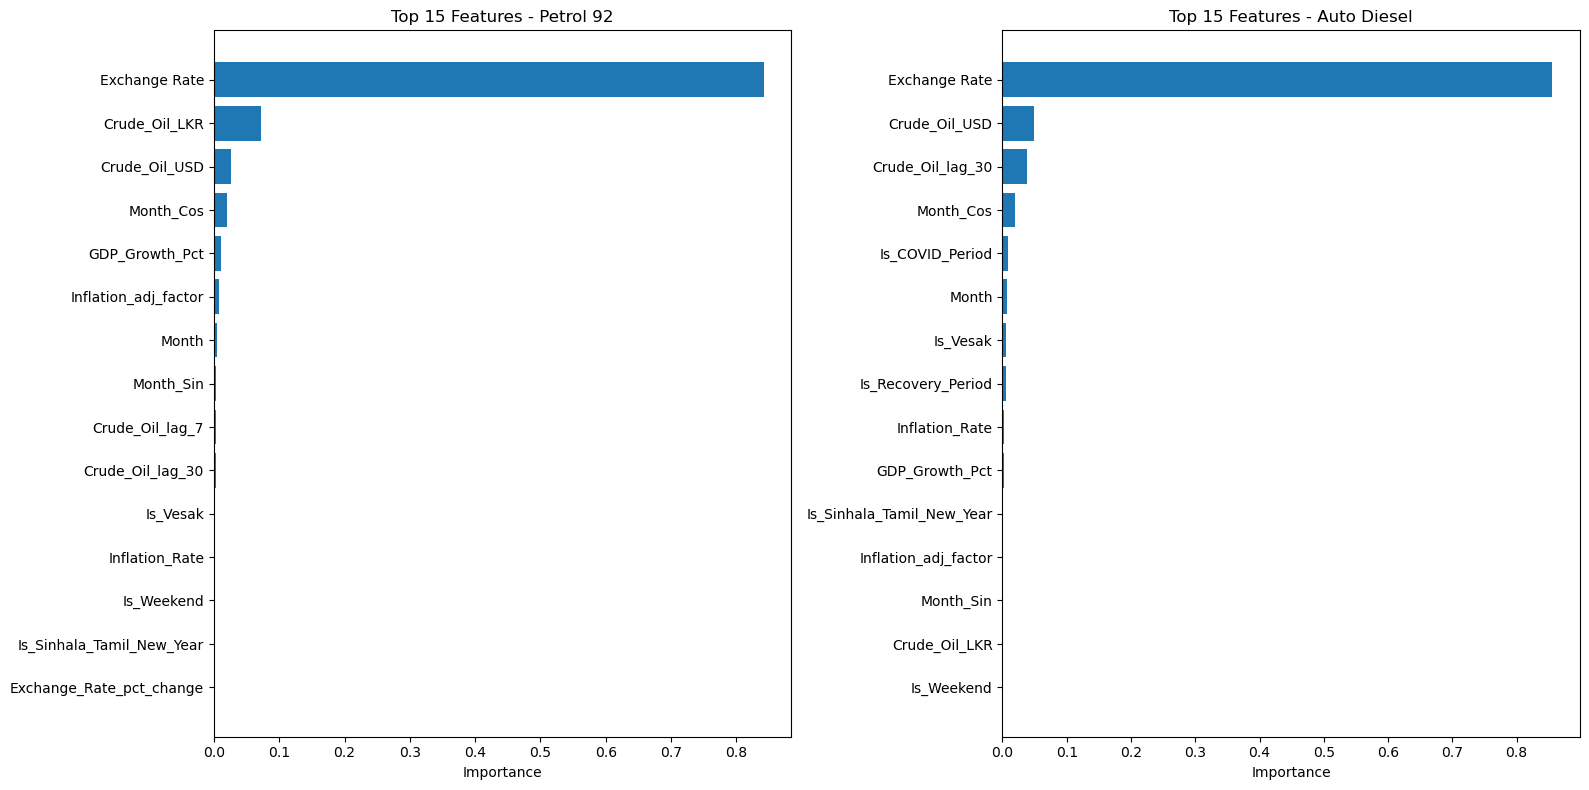

In [36]:
# %% [markdown]
# ## Feature Importance Analysis

# %%
if 'xgb_p92_tuned' in locals() and xgb_p92_tuned is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Petrol 92 Feature Importance
    feature_importance_p92 = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_p92_tuned.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    axes[0].barh(feature_importance_p92['feature'], feature_importance_p92['importance'])
    axes[0].set_xlabel('Importance')
    axes[0].set_title('Top 15 Features - Petrol 92')
    axes[0].invert_yaxis()
    
    # Auto Diesel Feature Importance
    if 'xgb_ad_tuned' in locals() and xgb_ad_tuned is not None:
        feature_importance_ad = pd.DataFrame({
            'feature': X_train.columns,
            'importance': xgb_ad_tuned.feature_importances_
        }).sort_values('importance', ascending=False).head(15)
        
        axes[1].barh(feature_importance_ad['feature'], feature_importance_ad['importance'])
        axes[1].set_xlabel('Importance')
        axes[1].set_title('Top 15 Features - Auto Diesel')
        axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('../reports/feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

In [37]:

# %% [markdown]
# ## Save Best Models

# %%
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

target_cols = ['LP_92', 'LP_95', 'LAD', 'LSD', 'LK']

# Save the best models (tuned XGBoost)
if 'xgb_p92_tuned' in locals() and xgb_p92_tuned is not None:
    joblib.dump(xgb_p92_tuned, '../models/xgb_petrol92_best.pkl')
    print("✓ Saved XGBoost Petrol 92 (tuned) model")

if 'xgb_ad_tuned' in locals() and xgb_ad_tuned is not None:
    joblib.dump(xgb_ad_tuned, '../models/xgb_diesel_best.pkl')
    print("✓ Saved XGBoost Diesel (tuned) model")

# Save feature names
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, '../models/feature_names.pkl')
print("✓ Saved feature names")

# Save best parameters
if 'best_params_p92' in locals():
    joblib.dump(best_params_p92, '../models/best_params_petrol92.pkl')
if 'best_params_ad' in locals():
    joblib.dump(best_params_ad, '../models/best_params_diesel.pkl')

print("\nAll models saved successfully!")

# Print final summary
if results:
    print("\n" + "="*50)
    print("TRAINING COMPLETE - FINAL RESULTS")
    print("="*50)
    print(f"Models trained: {len(results)}")
    
    petrol_results = results_df[results_df['Target'] == 'Petrol 92']
    if not petrol_results.empty:
        best_petrol = petrol_results.loc[petrol_results['RMSE'].idxmin()]
        print(f"\nBest Petrol 92 Model: {best_petrol['Model']}")
        print(f"  RMSE: {best_petrol['RMSE']:.2f} LKR")
        print(f"  MAE: {best_petrol['MAE']:.2f} LKR")
        print(f"  R²: {best_petrol['R2']:.3f}")
        print(f"  MAPE: {best_petrol['MAPE']:.2f}%")
    
    diesel_results = results_df[results_df['Target'] == 'Auto Diesel']
    if not diesel_results.empty:
        best_diesel = diesel_results.loc[diesel_results['RMSE'].idxmin()]
        print(f"\nBest Auto Diesel Model: {best_diesel['Model']}")
        print(f"  RMSE: {best_diesel['RMSE']:.2f} LKR")
        print(f"  MAE: {best_diesel['MAE']:.2f} LKR")
        print(f"  R²: {best_diesel['R2']:.3f}")
        print(f"  MAPE: {best_diesel['MAPE']:.2f}%")

✓ Saved XGBoost Petrol 92 (tuned) model
✓ Saved XGBoost Diesel (tuned) model
✓ Saved feature names

All models saved successfully!

TRAINING COMPLETE - FINAL RESULTS
Models trained: 6

Best Petrol 92 Model: XGBoost (Tuned)
  RMSE: 30.93 LKR
  MAE: 25.46 LKR
  R²: -0.976
  MAPE: 7.16%

Best Auto Diesel Model: XGBoost (Tuned)
  RMSE: 30.39 LKR
  MAE: 24.50 LKR
  R²: -0.110
  MAPE: 7.54%
